# Seq2Seq Model Training - T5

After failing to produce a good prompt generator using GANs, I have decided to give a try using Seq2Seq models. Previously, I tried to use BERT but this task does not really suit them, since BERT is mainly used for text prediction, pattern recognition, but does not really excel at text to text generation.

On the other hand, T5 developed by the Google Research team was trained with millions and billions of english grammar, sentence structures and its basic rules. Although the training takes way longer than BERT, the end result might still be interesting since this pretrained model was trained with large amounts of data. 

## Importing the data

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("data/training_data.csv")
df.head()

,sentence,prompts
0,He was accorded a State funeral and was buried...,A solemn State funeral procession unfolds in t...
1,In American English whilst is considered to be...,A vintage-style blackboard in a classic Americ...
2,Once again she is seen performing on a compute...,"A young woman in her mid-20s, of East Asian de..."
3,Hippety Hopper returns in McKimsons Pop Im Pop.,"A vibrant cartoon rabbit, Hippety Hopper, leap..."
4,Today their programs are available on the Inte...,"A sleek, modern digital interface displaying a..."


In [3]:
df.shape

(10000, 2)

## Cleaning the data

In [4]:
df = df[df['prompts'] != "PROHIBITED_CONTENT"].dropna()

In [5]:
df = df.drop_duplicates(subset=['prompts'])

In [6]:
df.shape

(2929, 2)

## Model training

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lewjj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
class PromptDataset(Dataset):
    def __init__(self, sentences, prompts, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.sentences = sentences
        self.prompts = prompts
        self.max_length = max_length
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        prompt = self.prompts[idx]
        
        input_text = sentence
        
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        targets = self.tokenizer(
            prompt,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze(),
        }

class PromptEvaluator:
    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    def calculate_bleu(self, reference, candidate):
        reference_tokens = nltk.word_tokenize(reference.lower())
        candidate_tokens = nltk.word_tokenize(candidate.lower())
        return sentence_bleu([reference_tokens], candidate_tokens)
    
    def calculate_meteor(self, reference, candidate):
        return meteor_score([reference.split()], candidate.split())
    
    def calculate_rouge(self, reference, candidate):
        scores = self.rouge_scorer.score(reference, candidate)
        return {
            'rouge1': scores['rouge1'].fmeasure,
            'rouge2': scores['rouge2'].fmeasure,
            'rougeL': scores['rougeL'].fmeasure
        }
    
    def evaluate_batch(self, references, candidates):
        metrics = {
            'bleu': [],
            'meteor': [],
            'rouge1': [],
            'rouge2': [],
            'rougeL': []
        }
        
        for ref, cand in zip(references, candidates):
            metrics['bleu'].append(self.calculate_bleu(ref, cand))
            metrics['meteor'].append(self.calculate_meteor(ref, cand))
            rouge_scores = self.calculate_rouge(ref, cand)
            metrics['rouge1'].append(rouge_scores['rouge1'])
            metrics['rouge2'].append(rouge_scores['rouge2'])
            metrics['rougeL'].append(rouge_scores['rougeL'])
        
        return {k: np.mean(v) for k, v in metrics.items()}

class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.train_metrics = []
        self.val_metrics = []
        
    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_metrics(self, metric_name):
        train_values = [m[metric_name] for m in self.train_metrics]
        val_values = [m[metric_name] for m in self.val_metrics]
        
        plt.figure(figsize=(10, 6))
        plt.plot(train_values, label=f'Training {metric_name}')
        plt.plot(val_values, label=f'Validation {metric_name}')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.upper())
        plt.title(f'Training and Validation {metric_name} Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs, evaluator):
    tracker = MetricsTracker()
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        train_refs = []
        train_preds = []
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                generated = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=128
                )
            
            predictions = tokenizer.batch_decode(generated, skip_special_tokens=True)
            references = tokenizer.batch_decode(labels, skip_special_tokens=True)
            
            train_refs.extend(references)
            train_preds.extend(predictions)
            
            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_loss = total_loss / len(train_loader)
        train_metrics = evaluator.evaluate_batch(train_refs, train_preds)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_refs, val_preds = [], []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                val_loss += outputs.loss.item()
                
                generated = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=128
                )
                
                predictions = tokenizer.batch_decode(generated, skip_special_tokens=True)
                references = tokenizer.batch_decode(labels, skip_special_tokens=True)
                
                val_refs.extend(references)
                val_preds.extend(predictions)
        
        avg_val_loss = val_loss / len(val_loader)
        val_metrics = evaluator.evaluate_batch(val_refs, val_preds)
        
        # Store metrics
        tracker.train_losses.append(avg_loss)
        tracker.val_losses.append(avg_val_loss)
        tracker.train_metrics.append(train_metrics)
        tracker.val_metrics.append(val_metrics)
        
        # Print epoch results
        print(f'\nEpoch {epoch + 1}/{num_epochs}:')
        print(f'Training Loss: {avg_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print('\nTraining Metrics:')
        for metric, value in train_metrics.items():
            print(f'{metric}: {value:.4f}')
        print('\nValidation Metrics:')
        for metric, value in val_metrics.items():
            print(f'{metric}: {value:.4f}')
    
    return tracker

def generate_prompts(sentence, model, tokenizer, device, num_return_sequences=3, max_length=128):
    model.eval()
    
    input_text = sentence
    
    inputs = tokenizer(
        input_text,
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors='pt'
    ).to(device)
    
    outputs = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_length=max_length,
        temperature=0.8,
        do_sample=True,
    )
    
    generated_prompts = [
        tokenizer.decode(output, skip_special_tokens=True)
        for output in outputs
    ]
    
    return generated_prompts

## Splitting data into train and test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    df['sentence'],
    df['prompts'],
    test_size=.2,
    random_state=50
)

## Initializing tokenizer and model 

In [10]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [11]:
# Prepare training data
training_data = pd.DataFrame({
    'sentence': X_train.sort_index(),
    'prompts': y_train.sort_index()
}).values
sentences, prompts = zip(*training_data)
dataset = PromptDataset(sentences, prompts, tokenizer)
dataloader = DataLoader(dataset, batch_size=8)
evaluator = PromptEvaluator()

In [12]:
# Prepare testing data
testing_data = pd.DataFrame({
    'sentence': X_test.sort_index(),
    'prompts': y_test.sort_index()
}).values
test_sentences, test_prompts = zip(*testing_data)
test_dataset = PromptDataset(test_sentences, test_prompts, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=8)

## Initiate training

In [13]:
# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Train model
tracker = train_model(model, dataloader, test_dataloader,
        optimizer, device, num_epochs=10,
        evaluator=evaluator)

Epoch 1/10: 100%|████████████████████████████████████████████████████████| 293/293 [1:43:26<00:00, 21.18s/it, loss=2.4]
C:\Users\lewjj\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\lewjj\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\lewjj\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho


Epoch 1/10:
Training Loss: 3.0282
Validation Loss: 2.3216

Training Metrics:
bleu: 0.0222
meteor: 0.1180
rouge1: 0.2352
rouge2: 0.0504
rougeL: 0.1719

Validation Metrics:
bleu: 0.0449
meteor: 0.1508
rouge1: 0.2632
rouge2: 0.0699
rougeL: 0.1988


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [19:39<00:00, 15.94s/it]



Epoch 2/10:
Training Loss: 2.4751
Validation Loss: 2.1175

Training Metrics:
bleu: 0.0512
meteor: 0.1741
rouge1: 0.3193
rouge2: 0.0822
rougeL: 0.2196

Validation Metrics:
bleu: 0.0627
meteor: 0.1835
rouge1: 0.3115
rouge2: 0.0900
rougeL: 0.2224


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [21:03<00:00, 17.08s/it]



Epoch 3/10:
Training Loss: 2.2859
Validation Loss: 2.0137

Training Metrics:
bleu: 0.0609
meteor: 0.1919
rouge1: 0.3409
rouge2: 0.0946
rougeL: 0.2318

Validation Metrics:
bleu: 0.0738
meteor: 0.2033
rouge1: 0.3397
rouge2: 0.1015
rougeL: 0.2385


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [17:42<00:00, 14.36s/it]



Epoch 4/10:
Training Loss: 2.1571
Validation Loss: 1.9397

Training Metrics:
bleu: 0.0659
meteor: 0.1995
rouge1: 0.3509
rouge2: 0.1005
rougeL: 0.2379

Validation Metrics:
bleu: 0.0845
meteor: 0.2161
rouge1: 0.3613
rouge2: 0.1148
rougeL: 0.2469


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [16:11<00:00, 13.13s/it]



Epoch 5/10:
Training Loss: 2.0629
Validation Loss: 1.8915

Training Metrics:
bleu: 0.0739
meteor: 0.2092
rouge1: 0.3632
rouge2: 0.1086
rougeL: 0.2435

Validation Metrics:
bleu: 0.0843
meteor: 0.2230
rouge1: 0.3676
rouge2: 0.1149
rougeL: 0.2478


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [20:00<00:00, 16.22s/it]



Epoch 6/10:
Training Loss: 1.9866
Validation Loss: 1.8519

Training Metrics:
bleu: 0.0770
meteor: 0.2146
rouge1: 0.3692
rouge2: 0.1115
rougeL: 0.2474

Validation Metrics:
bleu: 0.0900
meteor: 0.2299
rouge1: 0.3805
rouge2: 0.1238
rougeL: 0.2546


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [21:40<00:00, 17.58s/it]



Epoch 7/10:
Training Loss: 1.9212
Validation Loss: 1.8222

Training Metrics:
bleu: 0.0805
meteor: 0.2200
rouge1: 0.3753
rouge2: 0.1148
rougeL: 0.2496

Validation Metrics:
bleu: 0.0930
meteor: 0.2335
rouge1: 0.3821
rouge2: 0.1247
rougeL: 0.2561


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [18:49<00:00, 15.27s/it]



Epoch 8/10:
Training Loss: 1.8580
Validation Loss: 1.8014

Training Metrics:
bleu: 0.0840
meteor: 0.2243
rouge1: 0.3803
rouge2: 0.1191
rougeL: 0.2537

Validation Metrics:
bleu: 0.0956
meteor: 0.2360
rouge1: 0.3895
rouge2: 0.1282
rougeL: 0.2588


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [20:03<00:00, 16.26s/it]



Epoch 9/10:
Training Loss: 1.8088
Validation Loss: 1.7828

Training Metrics:
bleu: 0.0862
meteor: 0.2272
rouge1: 0.3842
rouge2: 0.1201
rougeL: 0.2556

Validation Metrics:
bleu: 0.0934
meteor: 0.2368
rouge1: 0.3911
rouge2: 0.1278
rougeL: 0.2580


Validation: 100%|██████████████████████████████████████████████████████████████████████| 74/74 [16:28<00:00, 13.35s/it]



Epoch 10/10:
Training Loss: 1.7551
Validation Loss: 1.7648

Training Metrics:
bleu: 0.0890
meteor: 0.2304
rouge1: 0.3866
rouge2: 0.1222
rougeL: 0.2565

Validation Metrics:
bleu: 0.0971
meteor: 0.2404
rouge1: 0.3965
rouge2: 0.1323
rougeL: 0.2607


## Testing out generation with the model

In [17]:
# Test generation
test_sentence = "programmer coding in a room"
generated_prompts = generate_prompts(test_sentence, model, tokenizer, device)

print(f"\nOriginal: {test_sentence}")
print("\nGenerated prompts:")
for i, prompt in enumerate(generated_prompts, 1):
    print(f"{i}. {prompt}")


Original: programmer coding in a room

Generated prompts:
1. A young programmer, around 10-12 years old with a determined expression, stands confidently in the heart of an open, modern lab. His black lab coat, adorned with intricate holographic patterns, gleams under the warm glow of a monitor. His muscular frame is clad in a crisp white lab coat with a white lab coat pocket, complete with a blue coding headset and a high-performance LED keyboard. His hands, slightly raised, work tirelessly, fingers coding intricate codes, while his hand gestures cautiously toward the device’s input. His


As we can see here, although the prompt gets cut off abruptly, it still conveys the meaning of the original sentence in an image prompt form without fail. This is exactly what we're looking for.

## Saving the model

In [15]:
# be sure to replace the path to prevent overwriting the previous model
torch.save(model, "models/prompt_generator_T5_v3")

## Model evaluation

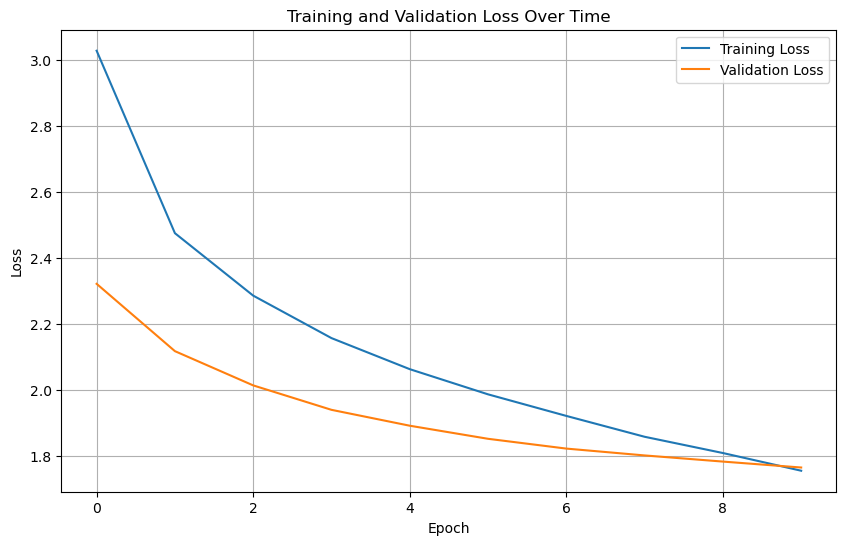

In [18]:
tracker.plot_losses()

As both training and validation loss decrease gradually over time, it proves that this model is experiencing good learning progress and is constantly improving over time without overfitting or underfitting.

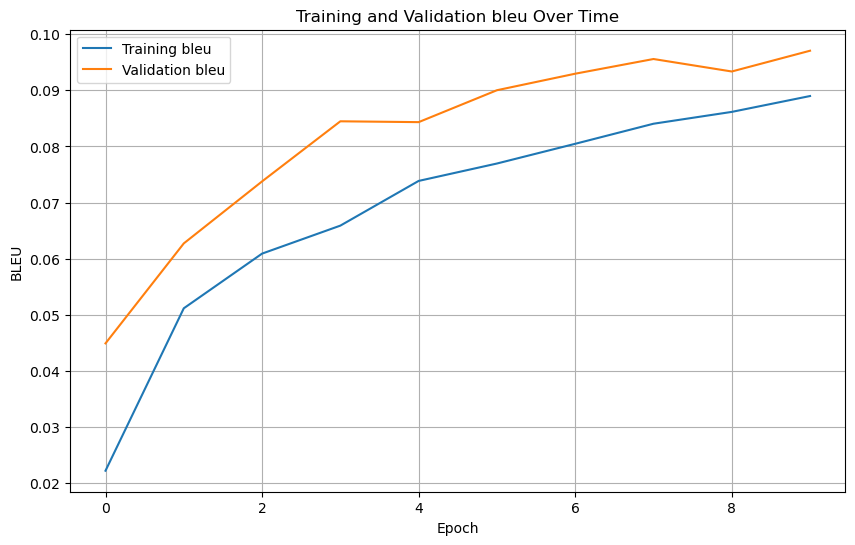

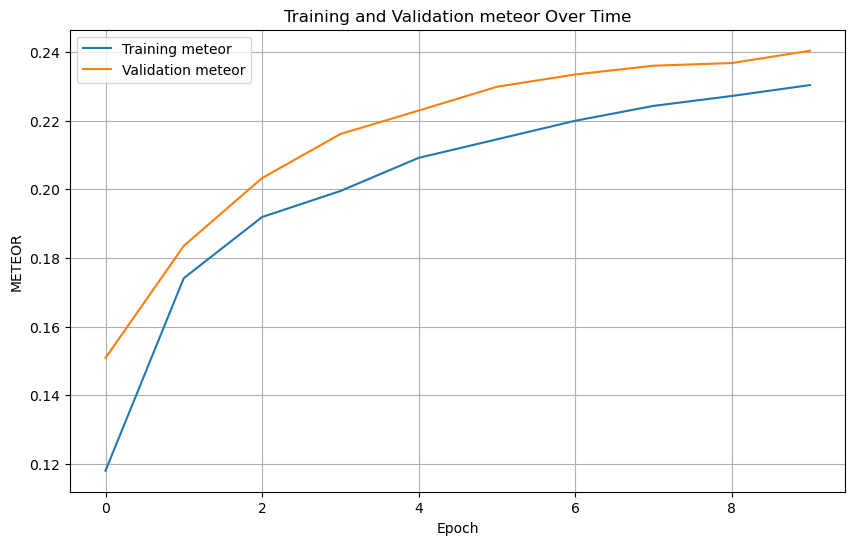

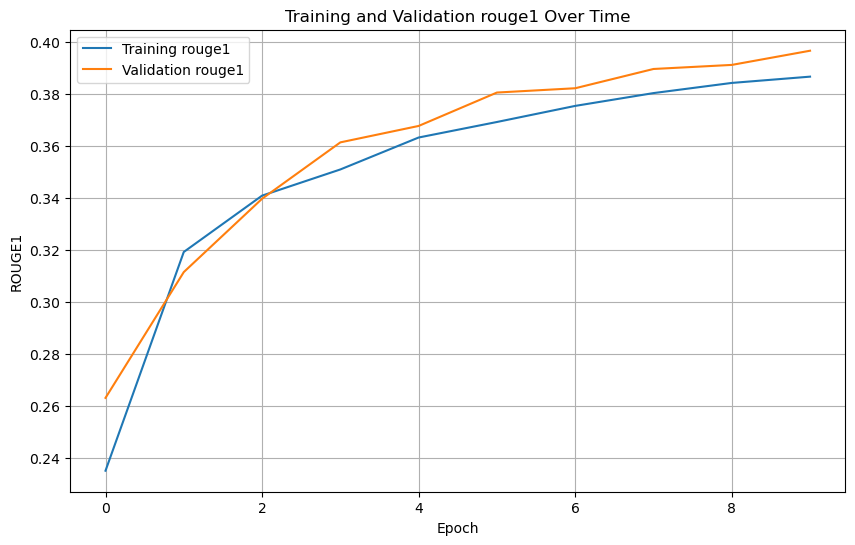

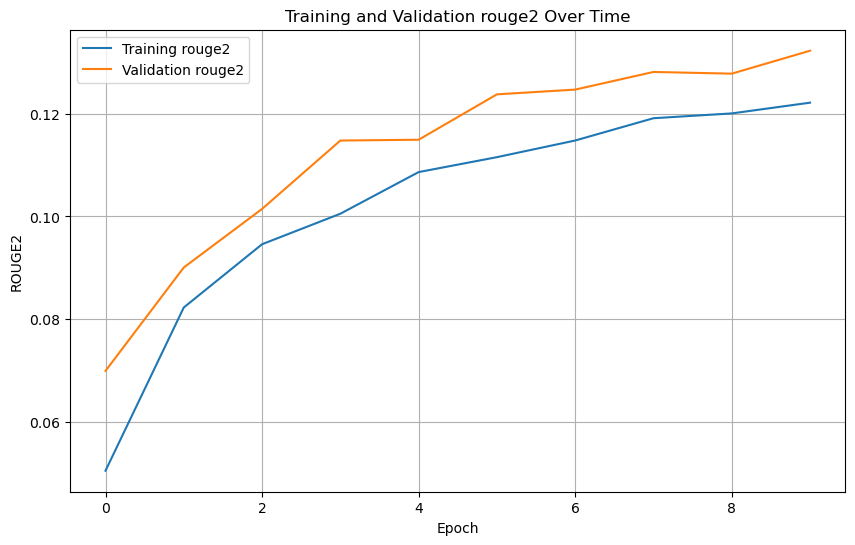

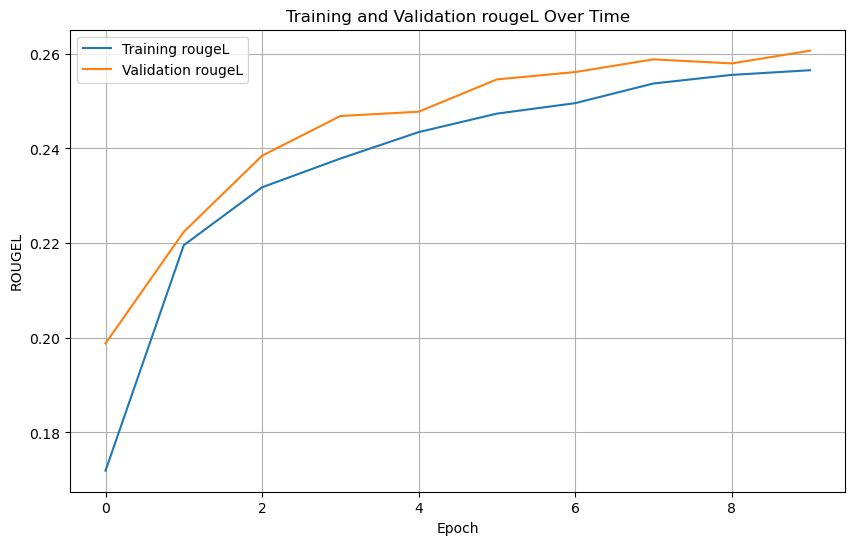

In [23]:
for metric in ['bleu', 'meteor', 'rouge1', 'rouge2', 'rougeL']:
    tracker.plot_metrics(metric)

The language scores from 5 different aspects also shows that the model is imrpoving over time. Our model is learning slowly.